# Fitting to a Binomial distribution to stochastic SIR model
-----


In [1]:
%pylab inline
import sys
sys.path.append('../')

Populating the interactive namespace from numpy and matplotlib


## load libraries

In [3]:
import importlib
import pydra
import gen_data_utils as gd
import plot_utils as pu
import scipy.stats as stats
from tqdm import tqdm

importlib.reload(pydra)
importlib.reload(gd)
importlib.reload(pu)

<module 'plot_utils' from '../plot_utils.py'>

## Set plotting parameters

In [4]:
import seaborn as sns
import matplotlib

sns.set_style("whitegrid",{"xtick.major.size": 8, "ytick.major.size": 8})
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('figure',**{'figsize'   : (6.4, 4.8)})
matplotlib.rc('font', **font)

## Generate mixture binomial data

In [5]:
n = 100 #population size
def gen_data(ps,pis,n=n,data_n=1000):
    pis = np.array(pis)
    ps = np.tile(np.array(ps),(data_n,1))
    rs = np.random.rand(data_n) < pis[0]/np.sum(pis)
    r_binoms = stats.binom(n,ps).rvs((data_n,2))
    result = np.array([r_binoms[i,r] for i,r in zip(range(data_n),rs.astype(int))])
    return result

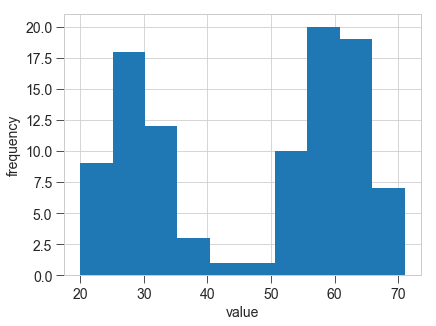

In [7]:
fig = plt.figure()
plt.hist(xs);
plt.xlabel('value');
plt.ylabel('frequency');

In [8]:
size = 5000
p1 = np.random.uniform(high=1.,low=0.,size=size)
p2 = np.random.uniform(high=1.,low=0.,size=size)
def gen_data_series(p1,p2):
    y = []
    for pp1,pp2 in zip(p1,p2):
        y.append(gen_data([pp1,pp2],[.5,.5],data_n=1))
    return np.array(y)

y = gen_data_series(p1,p2)

## Plot test data

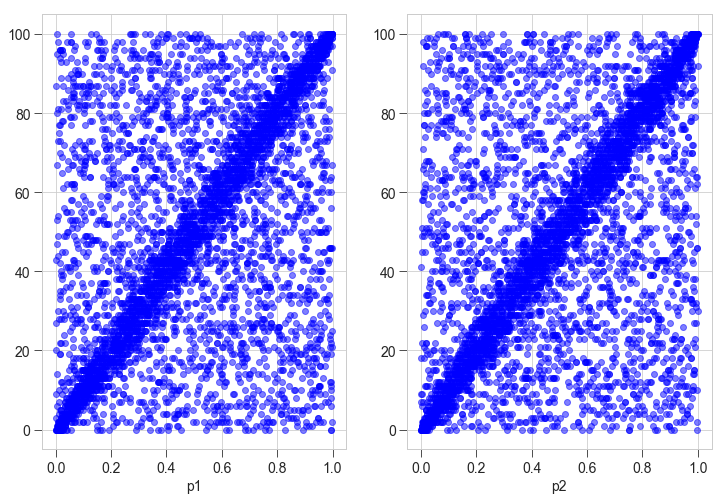

In [9]:
plt.figure(figsize=(12,8));
xs = [p1,p2]
x_label = ['p1','p2']

for i,(x,label) in enumerate(zip(xs,x_label)):
    plt.subplot(1,2,i+1);
    plt.plot(x,y,'bo',alpha=0.5);plt.xlabel(label);

## Load emulation model

In [10]:
cluster_size = 10
model = pydra.Pydra(cluster_size=cluster_size,output_size=1,layers=3,input_size=2,learning_rate=0.001,activation='selu',
                       dense_layer_size=64,output_distributions=['Binomial'],print_summary=True,params={'binomial_n':float(n)})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           192         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           4160        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [11]:
def shape_for_mdn(x):
    return x.reshape(x.size,1)


In [12]:
p1 = shape_for_mdn(p1)
p2 = shape_for_mdn(p2)
y = shape_for_mdn(y)
data = np.hstack((p1,p2))

In [13]:
history = model.fit(data, y, epochs=30, batch_size=50,
          verbose=1)

Epoch 1/30
5000/5000 [==============================] - 1s 142us/step - loss: 4.9022
Epoch 2/30
5000/5000 [==============================] - 0s 42us/step - loss: 4.3765
Epoch 3/30
5000/5000 [==============================] - 0s 41us/step - loss: 3.7988
Epoch 4/30
5000/5000 [==============================] - 0s 43us/step - loss: 3.6827
Epoch 5/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.6821
Epoch 6/30
5000/5000 [==============================] - 0s 43us/step - loss: 3.6249
Epoch 7/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.5826
Epoch 8/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.6038
Epoch 9/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.5473
Epoch 10/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.5479
Epoch 11/30
5000/5000 [==============================] - 0s 44us/step - loss: 3.5516
Epoch 12/30
5000/5000 [==============================] - 0s 43us/step - l

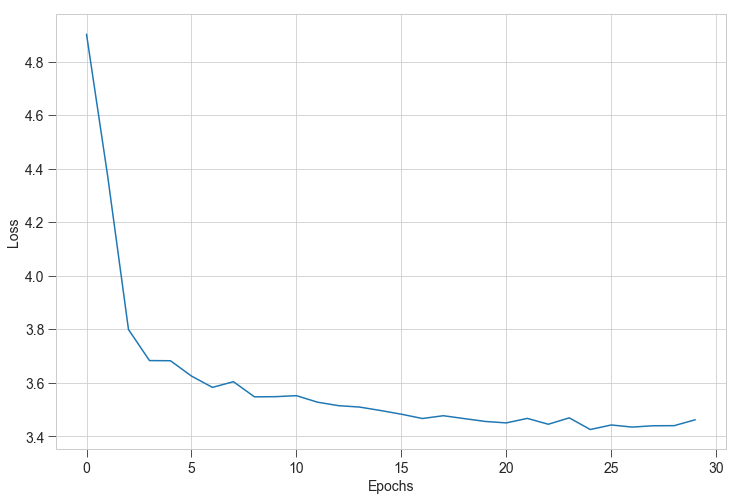

In [14]:
plt.figure(figsize=(12,8));
plt.plot(history.history['loss']);
plt.xlabel('Epochs'); plt.ylabel('Loss');

(100, 2)


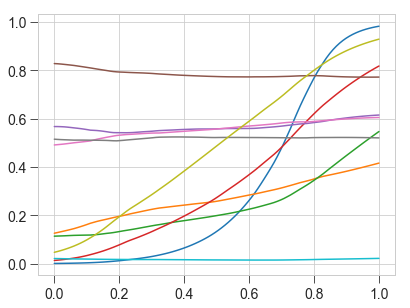

In [15]:
p_inputs = np.linspace(0,1,num=100)
c_inputs = 0.5*np.ones(100)
inputs = np.vstack((p_inputs,c_inputs)).T
print(inputs.shape)
for i in range(cluster_size):
    y_outputs = model.predict(inputs)[:,i]
    plt.plot(p_inputs,y_outputs);

In [16]:
from get_coefficients import get_mixture_coef
op = 0.3
y_outputs = model.predict(np.array([op,op]).reshape(1,2))
pi,sigma,mu = get_mixture_coef(y_outputs,num_components=cluster_size)
p = mu
n = 100.
v = n*p*(1-p)
mixture_mu = np.sum(pi*p*n)
print(np.sqrt(np.sum(pi*(n*n*p*p+v)) - mixture_mu**2))
print(np.sqrt(n*op*(1-op)))
print(np.sum(pi*p*n))
print(op*n)


4.866970719858727
4.58257569495584
29.851086
30.0


## Sample from $p_1$ and $p_2$ to compare samples from fitted MDN model to data

In [17]:
p1_test = np.random.uniform(high=1.,low=0.,size=size)
p2_test = np.random.uniform(high=1.,low=0.,size=size)
y_test = gen_data_series(p1_test,p2_test)
p1_test = shape_for_mdn(p1_test)
p2_test = shape_for_mdn(p2_test)
y_test = shape_for_mdn(y_test)
x_test = np.hstack((p1_test,p2_test))

# get y-predictions.
y_pred = model.generate_mdn_sample_from_ouput(x_test)


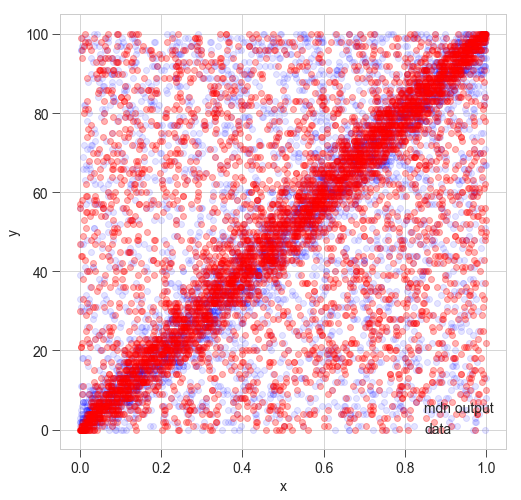

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(p1_test,y_pred,'bo',alpha=0.1,label='mdn output')
plt.plot(p1_test,y_test,'ro',alpha=0.3,label='data')
plt.legend();plt.xlabel('x');plt.ylabel('y');

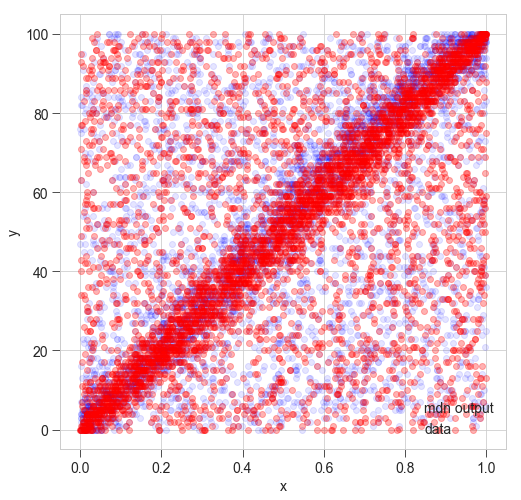

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(p2_test,y_pred,'bo',alpha=0.1,label='mdn output')
plt.plot(p2_test,y_test,'ro',alpha=0.3,label='data')
plt.legend();plt.xlabel('x');plt.ylabel('y');

## Plot across a given axis

In [20]:
#p2 = .5
p1_test = np.linspace(0.,1.,num=1000)
p2_test = p1_test#p2*np.ones(p1_test.shape)

p1_test = shape_for_mdn(p1_test)
p2_test = shape_for_mdn(p2_test)

x_test = np.hstack((p1_test,p2_test))

output = model.predict(x_test)

## plot directly from Pydra class (this includes the prediction step)

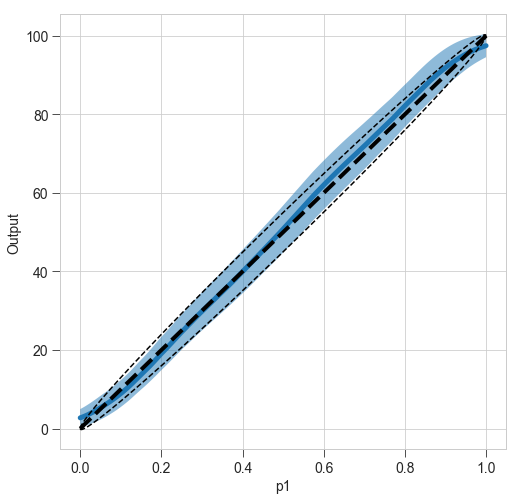

In [21]:
model.predict_plot(x_test,axis=0)
v = n*p1_test.flatten()*(1-p1_test.flatten())
plt.plot(p1_test.flatten(),n*p1_test.flatten(),'k--',lw=4.);
plt.plot(p1_test.flatten(),n*p1_test.flatten()+np.sqrt(v),'k--');
plt.plot(p1_test.flatten(),n*p1_test.flatten()-np.sqrt(v),'k--');
plt.xlabel('p1');
plt.title('');
plt.ylabel('Output');

# Generate SIR like data

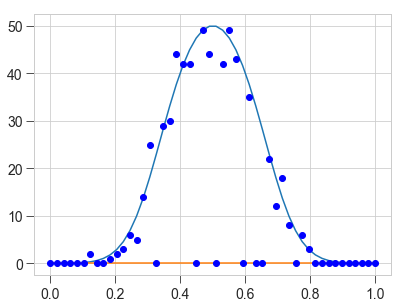

In [22]:
ts = np.linspace(0,1)
n = 100
data_n = len(ts)
p0 = .5 + .5*np.tanh(-20*(ts-.5)**2)
p1 = 0.*ts
ps = np.vstack((p0,p1))
plt.plot(ts,n*p0);
plt.plot(ts,n*p1);
pi0 = p0
pi1 = 1-p0
rs = np.random.rand(data_n) < pi0
r_binoms = stats.binom(n,ps).rvs()
r_binoms.shape
result = np.array([r_binoms[r,i] for i,r in zip(range(data_n),rs.astype(int))])
plt.plot(ts,result,'bo');

In [23]:
n = 100 #population size
def gen_SIR_data(n=n,data_n=1000):
    ts = np.linspace(0,1,num=data_n)
    n = 100
    p0 = .5 + .5*np.tanh(-20*(ts-.5)**2)
    p1 = 0.*ts
    ps = np.vstack((p0,p1))
    pi0 = p0
    pi1 = 1-p0
    rs = np.random.rand(data_n) < pi0
    r_binoms = stats.binom(n,ps).rvs()
    r_binoms.shape
    result = np.array([r_binoms[r,i] for i,r in zip(range(data_n),rs.astype(int))])
    return ts,result

In [24]:
x = []
y = []
for _ in range(100):
    ts,result = gen_SIR_data(n=n,data_n=1000)
    x.append(ts); y.append(result)
x = np.atleast_2d(np.array(x).flatten()).T
y = np.atleast_2d(np.array(y).flatten()).T

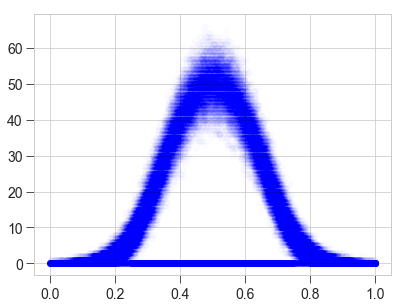

In [25]:
plt.plot(x,y,'bo',alpha=0.01)

In [26]:
cluster_size = 2
model = pydra.Pydra(cluster_size=cluster_size,output_size=1,layers=5,input_size=1,learning_rate=0.0001,activation='relu',
                       dense_layer_size=64,output_distributions=['Binomial'],print_summary=True,params={'binomial_n':float(n)})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           128         input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           4160        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           4160        dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (

In [27]:
history = model.fit(x, y, epochs=5, batch_size=50,
          verbose=1)

Epoch 1/5
100000/100000 [==============================] - 5s 48us/step - loss: 4.7186
Epoch 2/5
100000/100000 [==============================] - 4s 43us/step - loss: 1.8663
Epoch 3/5
100000/100000 [==============================] - 5s 54us/step - loss: 1.7815
Epoch 4/5
100000/100000 [==============================] - 5s 47us/step - loss: 1.7624
Epoch 5/5
100000/100000 [==============================] - 5s 48us/step - loss: 1.7543


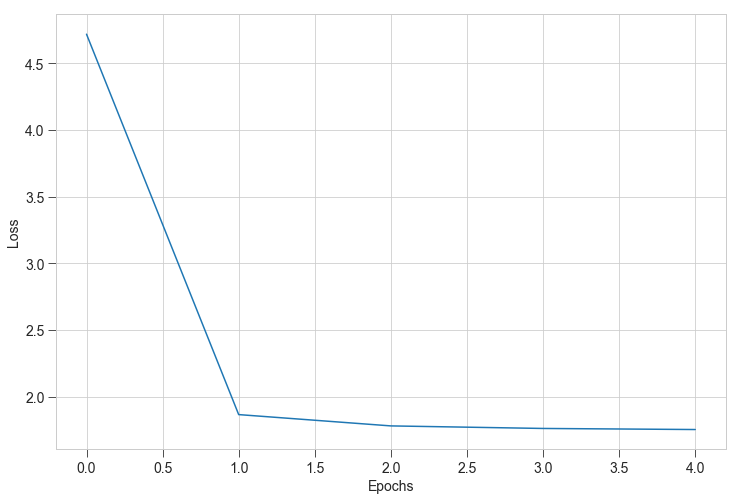

In [28]:
plt.figure(figsize=(12,8));
plt.plot(history.history['loss']);
plt.xlabel('Epochs'); plt.ylabel('Loss');

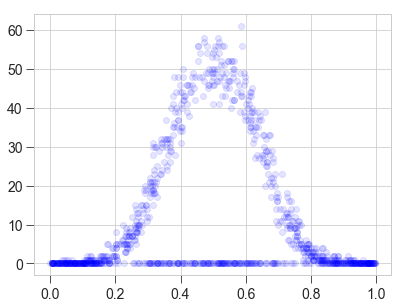

In [29]:
x_test = np.random.uniform(high=1.,low=0.,size=1000)
x_test = shape_for_mdn(x_test)

# get y-predictions.
y_pred = model.generate_mdn_sample_from_ouput(x_test)

plt.plot(x_test,y_pred,'bo',alpha=0.1);


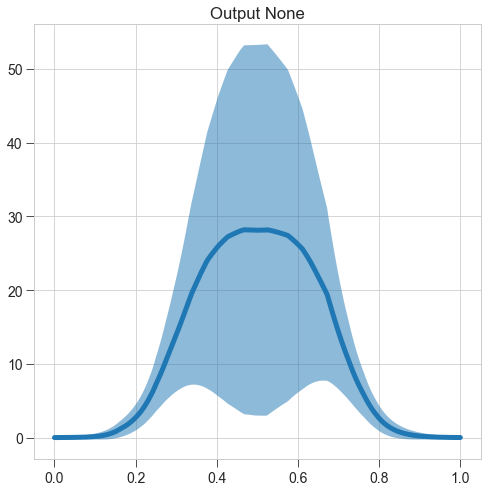

In [30]:
x_test = np.linspace(0.,1.,num=1000)
x_test = shape_for_mdn(x_test)

output = model.predict(x_test)

model.predict_plot(x_test,axis=0)